In [4]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os
import pickle
from tqdm.auto import tqdm

mpl.rcdefaults()
mpl_config = pd.read_csv('mpl_config.csv').to_dict(orient='records')[0]
mpl.rcParams.update(mpl_config)

## Data import

In [624]:
def compare_diff(x):
    """
    Given a 1D array x, return an array y of same length with:
        y[i] =  1 if x[i] > x[i-1]
        y[i] = -1 if x[i] < x[i-1]
        y[i] =  0 if x[i] == x[i-1]
    y[0] is set to 0 by convention.
    """
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=int)
    diff = np.diff(x)
    
    y[1:] = np.where(diff > 0, 1, np.where(diff < 0, -1, 0))
    
    return y


os.chdir('/Volumes/LaCie')

files_hercule_pmc =['HERCULE_20250528_SESSION_01','HERCULE_20250602_SESSION_00',\
       'HERCULE_20250603_SESSION_01','HERCULE_20250604_SESSION_00',\
      'HERCULE_20250604_SESSION_01','HERCULE_20250605_SESSION_00',\
      'HERCULE_20250605_SESSION_01','HERCULE_20250606_SESSION_00',\
      'HERCULE_20250612_SESSION_00',\
      'HERCULE_20250612_SESSION_02','HERCULE_20250616_SESSION_01']

for i in range(len(files_hercule_pmc)) :
    files_hercule_pmc[i]='HERCULE/' + files_hercule_pmc[i]

files_pmc = files_hercule_pmc

n_data_pmc_s = []
f_data_pmc_s = []
for file in tqdm(files_pmc) :
    n_data = np.load(file+'/headstage_1/data_0.005.npy')
    f_data = np.load(file+'/headstage_1/features_0.005.npy',allow_pickle=True)
    
    
    f_data_dict = {'Played_frequency':[],'Condition':[],'Block':[],'Frequency_changes':[],'Mock_frequency':[],'Mock_change':[]}

    for item in f_data:
        for key, value in item.items():
            f_data_dict[key].append(value)

    f_data = pd.DataFrame(f_data_dict)
    f_data['Change_direction'] = compare_diff(f_data['Played_frequency'].to_numpy())
    f_data['Mock_direction'] = compare_diff(f_data['Mock_frequency'].to_numpy())

    n_data=n_data.astype(float)

    n_data_pmc_s.append(n_data)
    f_data_pmc_s.append(f_data)
    

os.chdir('/Users/hugot/Documents/PHD/Felicie')

  0%|          | 0/11 [00:00<?, ?it/s]

In [625]:
from scipy.ndimage import gaussian_filter

for i in tqdm(range(len(n_data_pmc_s))) :
    n_data_smooth = gaussian_filter(n_data_pmc_s[i],sigma=10,axes=1)
    n_data_pmc_s[i] = n_data_smooth

  0%|          | 0/11 [00:00<?, ?it/s]

In [626]:
with open("Save/hercule_pmc", "wb") as fp:   #Pickling
    pickle.dump(n_data_pmc_s, fp)

with open("Save/hercule_pmc_features", "wb") as fp:   #Pickling
    pickle.dump(f_data_pmc_s, fp)

In [5]:
with open("Save/hercule_a1", "rb") as fp:   # Unpickling
     n_data_a1_s = pickle.load(fp)

with open("Save/hercule_features", "rb") as fp:
     f_data_a1_s = pickle.load(fp)

with open("Save/hercule_pmc", "rb") as fp:
     n_data_pmc_s = pickle.load(fp)

with open("Save/hercule_pmc_features", "rb") as fp:
     f_data_pmc_s = pickle.load(fp)

## Analysis PMC

In [6]:
w_size = 100
def get_event_vicinity(bool_array, window_size=100):
    """
    Return a 2D array of indices around True values in a boolean array,
    skipping events that overlap more than 50% with previous ones.

    Parameters:
        bool_array (np.ndarray): 1D boolean array.
        window_size (int): Number of indices before and after each True value.

    Returns:
        np.ndarray: 2D array of index windows, one per event.
    """
    event_indices = np.where(bool_array)[0]
    total_len = len(bool_array)
    full_window_size = window_size 
    last_window_end = -np.inf
    result = []

    for idx in event_indices:
        start = max(0, idx - int(window_size/3))
        end = min(total_len, idx + int(2*window_size/3)+ 1)
        indices = np.arange(start, end)

        # Pad if at edge
        if len(indices) < window_size:
            pad_len = full_window_size - len(indices)
            indices = np.pad(indices, (0, pad_len), mode='constant', constant_values=-1)

        # Check for overlap with previous event
        if start < last_window_end:
            overlap = last_window_end - start
            if overlap > 0: # window_size//5:
                continue  # Too much overlap, skip this event

        result.append(indices)
        last_window_end = end  # update end of last accepted window

    return np.array(result)

def compute_mean_trajectories(trajectories, vicinity_indices, event_values):
    """
    Computes the mean trajectory in the vicinity of events grouped by event label.

    Parameters:
        trajectories (np.ndarray): [T, D] array of trajectory over time.
        vicinity_indices (np.ndarray): [N_events, window_size] of indices for each event.
        event_values (np.ndarray): [N_events] of numerical event labels (can be float or int).

    Returns:
        dict: {label: mean_trajectory} where mean_trajectory is [window_size, D]
    """
    unique_labels = np.unique(event_values)
    result = {}

    for label in unique_labels:
        # Find all events with this label
        label_mask = event_values == label
        label_indices = vicinity_indices[label_mask]

        valid_segments = []
        for inds in label_indices:
            # Filter out -1 (padding from earlier step)
            valid_mask = inds >= 0
            if np.any(valid_mask):
                valid_inds = inds[valid_mask]
                segment = trajectories[valid_inds]
                # Pad with NaNs if needed (for edge events)
                if segment.shape[0] < inds.shape[0]:
                    padded = np.full((inds.shape[0], trajectories.shape[1]), np.nan)
                    padded[valid_mask] = segment
                    segment = padded
                valid_segments.append(segment)

        if valid_segments:
            mean_traj = np.nanmean(np.stack(valid_segments), axis=0)
            result[label] = mean_traj

    return result

In [7]:
f_min, f_max = 1000, 5000
all_traj_track_p, all_traj_track_m = [], []
all_traj_pb_p, all_traj_pb_m = [], []

def process_traj(n_data, event_idx, event_freq):
    """Compute and filter mean trajectories."""
    m_traj = compute_mean_trajectories(n_data.T, event_idx, event_freq)
    return {k: v for k, v in m_traj.items() if f_min <= k <= f_max}

for n_data, f_data in zip(n_data_pmc_s, f_data_pmc_s):
    direc       = f_data['Change_direction'].to_numpy()
    mock_direc  = f_data['Mock_direction'].to_numpy()
    freq        = f_data['Played_frequency'].to_numpy()
    mock        = f_data['Mock_frequency'].to_numpy()
    triggers    = f_data['Frequency_changes'].to_numpy()
    triggers_mock = f_data['Mock_change'].to_numpy()
    condition   = f_data['Condition'].to_numpy()

    trigger_map = {
        'track_p': (triggers * (condition == 0) * (direc == 1),  freq),
        'track_m': (triggers * (condition == 0) * (direc == -1), freq),
        'pb_p':    (triggers_mock * (condition == 1) * (mock_direc == 1),  mock),
        'pb_m':    (triggers_mock * (condition == 1) * (mock_direc == -1), mock),
    }

    results = {}
    for key, (trig, arr) in trigger_map.items():
        event_idx = get_event_vicinity(trig, w_size)
        event_freq = arr[event_idx[:, w_size - 1]]
        results[key] = process_traj(n_data, event_idx, event_freq)

    all_traj_track_p.append(results['track_p'])
    all_traj_track_m.append(results['track_m'])
    all_traj_pb_p.append(results['pb_p'])
    all_traj_pb_m.append(results['pb_m'])


In [8]:
def pseudo_trajectories(mean_traj_dicts):
    """
    Concatenate mean trajectories across sessions by label along the feature axis.

    Parameters:
        mean_traj_dicts (list of dict): Each dict maps label to [T, D] mean trajectory arrays.

    Returns:
        pd.DataFrame: with columns ['trajectory', 'label'].
                     'trajectory' is a [T, D_total] array for each label.
    """
    grouped_traj = {key:[] for key in mean_traj_dicts[0].keys()}

    # Group all trajectories by label
    for session_dict in mean_traj_dicts:
        for label, traj in session_dict.items():
            grouped_traj[label].append(traj)

    # Concatenate along columns (axis=1)
    data = []
    for label, traj_list in grouped_traj.items():
        concatenated = np.concatenate(traj_list, axis=1)  # shape: [T, D_total]
        data.append((concatenated, label))

    # Build the DataFrame
    df = pd.DataFrame(data, columns=["trajectory", "label"])
    return df


traj_df_track_p, traj_df_track_m = pseudo_trajectories(all_traj_track_p), pseudo_trajectories(all_traj_track_m)
traj_df_pb_p, traj_df_pb_m = pseudo_trajectories(all_traj_pb_p), pseudo_trajectories(all_traj_pb_m)

In [10]:
from sklearn.decomposition import PCA
import numpy as np

def standardize(X):
    """Z-score standardization per feature."""
    mean = X.mean(axis=0)
    std = X.std(axis=0, ddof=0)
    std[std == 0] = 1
    return (X - mean) / std

# Stack and combine trajectory matrices
traj_mats = [
    np.stack(traj_df_track_p['trajectory']),
    np.stack(traj_df_track_m['trajectory']),
    np.stack(traj_df_pb_p['trajectory']),
    np.stack(traj_df_pb_m['trajectory']),
    # np.stack(traj_df_pb_mock['trajectory'])  # optional
]
traj_mat_all = np.concatenate(traj_mats, axis=0)

# Flatten for PCA
n_trials, n_time, n_features = traj_mat_all.shape
traj_mat_flat = standardize(traj_mat_all.reshape(n_trials * n_time, n_features))

# PCA
n_comp = 10
pca_all = PCA(n_components=n_comp)
traj_PC_all_flat = pca_all.fit_transform(traj_mat_flat)

# Reshape back to (trial, time, components)
traj_PC_all = traj_PC_all_flat.reshape(n_trials, n_time, n_comp)

# Split results back into groups
nb_freq = traj_mats[0].shape[0]
traj_PC_track_p, traj_PC_track_m, traj_PC_pb_p, traj_PC_pb_m = [
    traj_PC_all[i * nb_freq:(i + 1) * nb_freq] for i in range(len(traj_mats))
]



In [11]:
with open("Save/PCA_pmc_1000-5000", "wb") as fp:   #Pickling
    pickle.dump(pca_all, fp)

### Visualization

In [ ]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, hsv_to_rgb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import splprep, splev, interp1d
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection


def create_white_to_color_colormaps(n_colors=16):
    """
    Create a list of colormaps transitioning from white to evenly spaced colors on the HSV wheel.

    Parameters:
        n_colors (int): Number of distinct colormaps to generate.

    Returns:
        list of LinearSegmentedColormap: List of custom colormaps.
    """
    colormaps = []
    for i in range(n_colors):
        hue = i / n_colors  # evenly spaced hue
        color = mcolors.hsv_to_rgb([hue, 1.0, 1.0])  # pure hue at full saturation/value
        cmap = mcolors.LinearSegmentedColormap.from_list(
            f'white_to_color_{i}', [(1, 1, 1), color], N=256
        )
        colormaps.append(cmap)
    return colormaps
    
def get_hsv_colors(n_colors=16):
    """Generate evenly spaced HSV colors converted to RGB."""
    return [mcolors.hsv_to_rgb([i / n_colors, 1.0, 1.0]) for i in range(n_colors)]

def add_phase_gradient_legend(ax, colors, tick_labels=None, vertical=False):
    """
    Draws a phase gradient legend on an existing axis.

    Parameters:
        ax (matplotlib.axes.Axes): Axis on which to draw the gradient.
        colors (list): List of RGB colors defining the gradient.
        tick_labels (list): Optional list of tick labels (must match len(colors)).
        vertical (bool): If True, draw vertically instead of horizontally.
    """
    n = len(colors)
    steps = 32  # Resolution per segment for smoothness
    cmap = mcolors.LinearSegmentedColormap.from_list("phase_gradient", colors)

    if vertical:
        gradient = np.linspace(0, 1, n * steps).reshape(-1, 1)
        ax.imshow(gradient, aspect='auto', cmap=cmap, origin='lower')
        ax.set_xticks([])
        tick_positions = np.linspace(0, gradient.shape[0] - 1, n)
        ax.set_yticks(tick_positions)
        if tick_labels:
            ax.set_yticklabels(tick_labels)
        else:
            ax.set_yticklabels([f"{i}" for i in range(n)])
    else:
        gradient = np.linspace(0, 1, n * steps).reshape(1, -1)
        ax.imshow(gradient, aspect='auto', cmap=cmap)
        ax.set_yticks([])
        tick_positions = np.linspace(0, gradient.shape[1] - 1, n)
        ax.set_xticks(tick_positions)
        if len(tick_labels)>0:
            ax.set_xticklabels(tick_labels, rotation=45, ha='right')
        else:
            ax.set_xticklabels([f"{i}" for i in range(n)])
    
    ax.tick_params(axis='both', length=0)

def add_inset_phase_legend(main_ax, colors, tick_labels=None, location='upper right', size="30%", pad=0.05):
    """
    Adds a compact phase gradient legend to an existing axis using an inset.

    Parameters:
        main_ax (matplotlib.axes.Axes): The main axis to attach the legend to.
        colors (list): List of RGB colors defining the gradient.
        tick_labels (list): List of tick labels for each color.
        location (str): Location inside main_ax to place the inset ('lower right', 'upper left', etc.).
        size (str or tuple): Size of the inset axes, e.g., '30%' or (width, height).
        pad (float): Padding from edge of the main_ax.
    """
    n = len(colors)
    steps = 32
    gradient = np.linspace(0, 1, n * steps).reshape(1, -1)
    cmap = LinearSegmentedColormap.from_list("phase_gradient", colors)

    # Create inset axis
    inset_ax = inset_axes(main_ax, width=size, height="5%", loc=location, borderpad=pad)
    inset_ax.imshow(gradient, aspect='auto', cmap=cmap)
    inset_ax.set_yticks([])

    tick_positions = np.linspace(0, gradient.shape[1] - 1, n)
    inset_ax.set_xticks(tick_positions)

    if len(tick_labels)>0:
        inset_ax.set_xticklabels(tick_labels, rotation=45, ha='right',fontsize=12)
        inset_ax.set_title('Frequency change',fontsize=15)
    else:
        inset_ax.set_xticklabels([str(i) for i in range(n)])

    inset_ax.tick_params(axis='x', length=0)
    
def draw_traj(traj,ax,cmap,three_d=False) :
    t_length=len(traj)
    for i in range(t_length-1):
        color = cmap(0.1+0.9*i / (t_length - 1))
        if three_d :
            ax.plot(traj[i:i+2,0],traj[i:i+2,1],traj[i:i+2,2],color=color,linewidth=5)
        else :
            ax.plot(traj[i:i+2,0],traj[i:i+2,1],color=color,linewidth=4)

def plot_gradient_curve(points, base_colors, ax, n_interp=200, smooth=0, marker='o', lw=2, alpha=0.8):
    """
    Fit a smooth curve through points (2D or 3D) and color it using HSV/RGB base colors.

    Parameters
    ----------
    points : array-like, shape (N, 2) or (N, 3)
        Input coordinates of the curve anchor points.
    base_colors : array-like, shape (N, 3)
        RGB colors for each anchor point.
    ax : matplotlib Axes or Axes3D
        Axis to plot on.
    n_interp : int
        Number of interpolation points for smoothness.
    smooth : float
        Spline smoothing factor (0 = exact fit).
    marker : str
        Marker for original points.
    lw : float
        Line width.
    alpha : float
        Transparency for the gradient line.
    """
    points = np.asarray(points)
    base_colors = np.asarray(base_colors)
    N, dim = points.shape
    if dim not in (2, 3):
        raise ValueError("Points must be either 2D or 3D.")

    # Parameterize the spline by normalized arc length
    distances = np.linalg.norm(np.diff(points, axis=0), axis=1)
    cumulative_dist = np.insert(np.cumsum(distances), 0, 0)
    cumulative_dist /= cumulative_dist[-1] if cumulative_dist[-1] != 0 else 1.0

    # Fit spline in each dimension
    tck, u = splprep(points.T, s=smooth, k=min(3, N-1))
    u_interp = np.linspace(0, 1, n_interp)
    coords_interp = splev(u_interp, tck)
    curve_points = np.stack(coords_interp, axis=1)

    # Interpolate colors across u
    interp_r = interp1d(u, base_colors[:, 0], kind='linear', fill_value="extrapolate")
    interp_g = interp1d(u, base_colors[:, 1], kind='linear', fill_value="extrapolate")
    interp_b = interp1d(u, base_colors[:, 2], kind='linear', fill_value="extrapolate")
    rgb_interp = np.stack([
        interp_r(u_interp),
        interp_g(u_interp),
        interp_b(u_interp)
    ], axis=1)

    # Build segments for gradient
    segments = np.stack([curve_points[:-1], curve_points[1:]], axis=1)
    segment_colors = rgb_interp[:-1]

    if dim == 2:
        lc = LineCollection(segments, colors=segment_colors, linewidths=lw, alpha=alpha)
        ax.add_collection(lc)
        ax.scatter(points[:, 0], points[:, 1], c=base_colors, edgecolor='k', marker=marker, s=40, zorder=3)
    else:
        lc = Line3DCollection(segments, colors=segment_colors, linewidths=lw, alpha=alpha)
        ax.add_collection3d(lc)
        ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                   c=base_colors, edgecolor='k', marker=marker, s=40, zorder=3)


Text(0, 0.5, 'PC2')

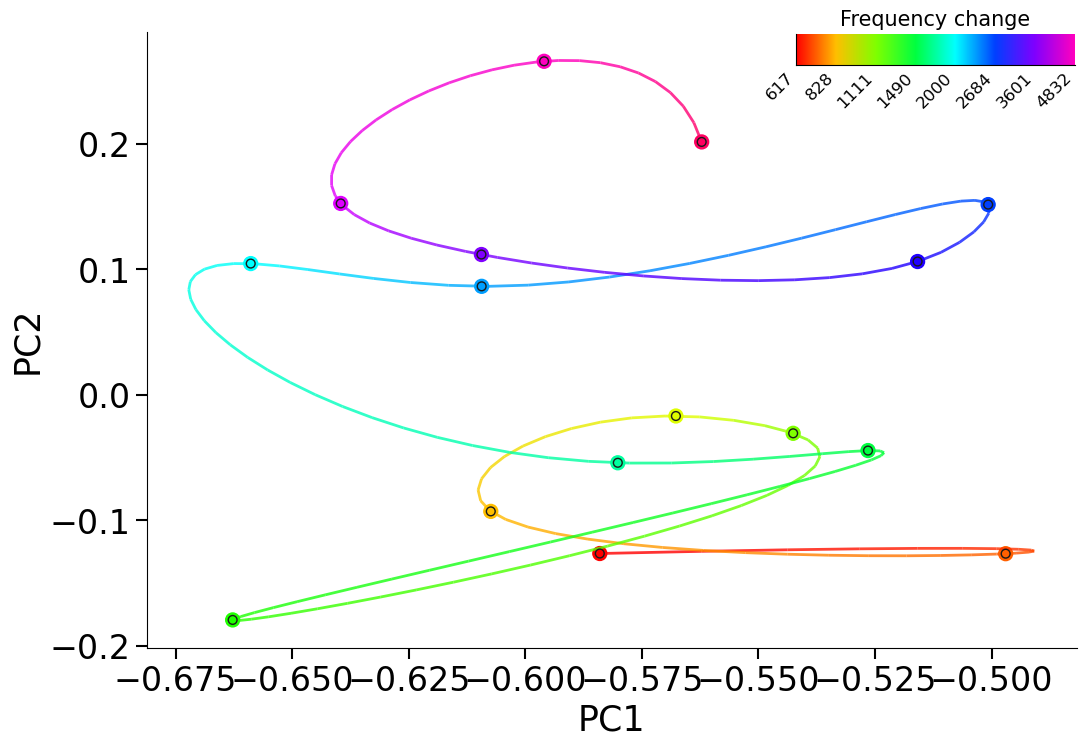

In [824]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

traj_toplot = traj_PC_pb_m

nb_times = len(traj_toplot[0])

start_time = int(nb_times*0.2)
stop_time = int(nb_times*0.9)

"""
for i in range(len(traj_toplot)) :
    draw_traj(traj_toplot[i][start_time:stop_time,:2],ax,cmaps[i])
"""
    
colors = get_hsv_colors(len(traj_toplot))



ax.scatter(traj_toplot[:,stop_time,0],traj_toplot[:,stop_time,1],c=colors,s=100)
#ax.scatter(traj_PC_pb[:,-1,1],traj_PC_pb[:,-1,2],c=colors,s=100)
add_inset_phase_legend(ax, colors[::2],tick_labels=traj_df_track_p['label'].to_numpy().astype(int)[::2])
plot_gradient_curve(traj_toplot[:,stop_time,:2],colors, ax)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

#plt.savefig('Plots/SVG/tonotopy_traj_tracking_-_hstage1.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_traj_tracking_-_hstage1.PNG', dpi = 300,bbox_inches='tight')

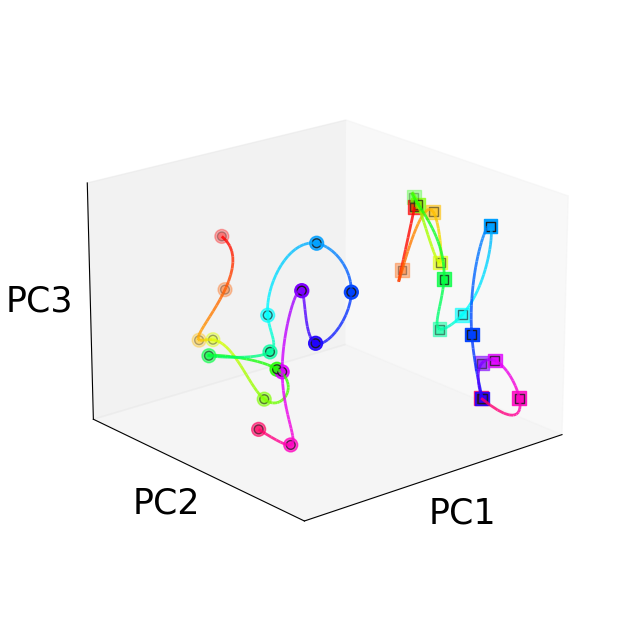

In [839]:
from scipy.interpolate import splprep, splev

cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
colors = get_hsv_colors()

traj_toplot1 = (traj_PC_track_p + traj_PC_track_m)/2
traj_toplot2 = (traj_PC_pb_p + traj_PC_pb_m)/2

ax.scatter(traj_toplot1[:,-1,0],traj_toplot1[:,-1,1],traj_toplot1[:,-1,2],c=colors,s=100)
plot_gradient_curve(traj_toplot1[:,-1,:3],colors, ax)

ax.scatter(traj_toplot2[:,-1,0],traj_toplot2[:,-1,1],traj_toplot2[:,-1,2],c=colors,s=100,marker='s')
plot_gradient_curve(traj_toplot2[:,-1,:3],colors, ax,marker='s')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.85)
ax.view_init(azim=50, elev=20)

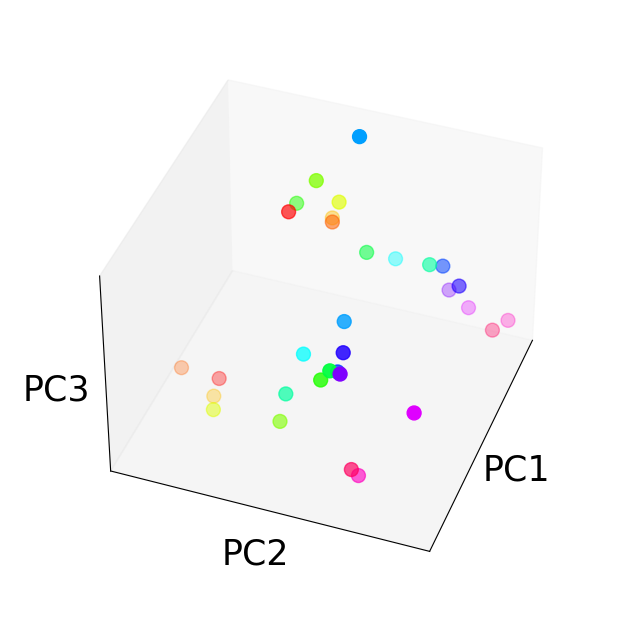

In [618]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
colors = get_hsv_colors()


ax.scatter(traj_PC_track_pmc[:,-1,0],traj_PC_track_pmc[:,-1,1],traj_PC_track_pmc[:,-1,2],c=colors,s=100)
ax.scatter(traj_PC_pb_pmc[:,-1,0],traj_PC_pb_pmc[:,-1,1],traj_PC_pb_pmc[:,-1,2],c=colors,s=100)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.85)
ax.view_init(azim=20, elev=40)
#plt.savefig('Plots/SVG/tonotopy_comparison_hstage1.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_comparison_hstage1.png', dpi = 300,bbox_inches='tight')